In [45]:
import keras
from keras.layers import Layer, Conv2D, Reshape, Dense, Conv2DTranspose, UpSampling2D, Flatten
from keras import Model
import tensorflow as tf

In [46]:
# Variational Autoencoder

class Encoder(Layer):
    def __init__(self, latent_dim=2, name="encoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.latent_dim = latent_dim

        self.conv1 = Conv2D(32, 3, activation='relu', strides=2, padding='same')
        self.conv2 = Conv2D(64, 3, activation='relu', strides=2, padding='same')
        self.flatten = Flatten()
        self.dense = Dense(16, activation='relu')
        self.dense_mean = Dense(latent_dim, name='z_mean')
        self.dense_log_var = Dense(latent_dim, name='z_log_var')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense(x)

        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        encoder_output = [z_mean, z_log_var]

        return encoder_output

class Sampler(Layer):
    def call(self, z_mean, z_log_var):
        batch_size = z_mean.shape[0]
        z_size = z_mean.shape[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Decoder(Layer):
    def __init__(self, latent_dim=2, name="decoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.dense = Dense(7 * 7 * 64, activation='relu')
        self.reshape = Reshape((7, 7, 64))
        self.conv1 = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')
        self.conv2 = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')
        self.conv3 = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')


    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.conv2(x)
        decoder_output = self.conv3(x)

        return decoder_output

class VAE(Model):
    def __init__(self, latent_dim=2, name="vae", **kwargs):
        super().__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim)
        self.sampler = Sampler()
        self.decoder = Decoder(latent_dim=latent_dim)

        # loss functions tranckers
        self.total_loss_tracker = keras.metrics.Mean(name="total_less")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = self.decoder(z)

            # compute losses
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) # KL divergence
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)

            # compute gradient
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

            # update trackers
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)

            return {
                "total_loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()
            }

    def call(self, inputs):
        x = self.Encoder(inputs)
        autoencoder_output = self.Decoder(x)

        return autoencoder_output

In [131]:
import tensorflow as tf
from keras import datasets, layers, models
from keras.datasets import fashion_mnist
import numpy as np

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

train_images = tf.expand_dims(train_images, axis=-1)
test_images = tf.expand_dims(test_images, axis=-1)

X = np.concatenate([train_images, test_images], axis=0)
Y = np.concatenate([train_labels, test_labels])


(70000,)


In [49]:
vae = VAE(2)
vae.compile(optimizer='adam', run_eagerly=True)
vae.fit(
    X,
    epochs=10,
    batch_size=128)

Epoch 1/10
547/547 [==============================] - 37s 63ms/step - total_loss: 393.1521 - reconstruction_loss: 354.4920 - kl_loss: 3.7408
Epoch 2/10
547/547 [==============================] - 35s 64ms/step - total_loss: 323.6434 - reconstruction_loss: 313.9777 - kl_loss: 4.8098
Epoch 3/10
547/547 [==============================] - 35s 63ms/step - total_loss: 309.2199 - reconstruction_loss: 301.6290 - kl_loss: 4.2131
Epoch 4/10
547/547 [==============================] - 35s 63ms/step - total_loss: 290.1510 - reconstruction_loss: 279.6259 - kl_loss: 4.6626
Epoch 5/10
547/547 [==============================] - 34s 62ms/step - total_loss: 274.6033 - reconstruction_loss: 268.8766 - kl_loss: 4.7640
Epoch 6/10
547/547 [==============================] - 35s 63ms/step - total_loss: 271.3839 - reconstruction_loss: 265.4518 - kl_loss: 4.6540
Epoch 7/10
547/547 [==============================] - 34s 62ms/step - total_loss: 268.7390 - reconstruction_loss: 263.6537 - kl_loss: 4.5428
Epoch 8/10
54

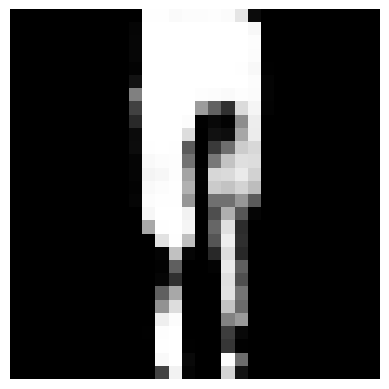

In [122]:
# visualize an image

import matplotlib.pyplot as plt

sample = vae.sampler(tf.convert_to_tensor([[1, 10]], dtype=tf.float32), 2)
synth = vae.decoder(sample).numpy()
plt.axis("off")
plt.imshow(synth.reshape((28, 28)), cmap="Greys_r")

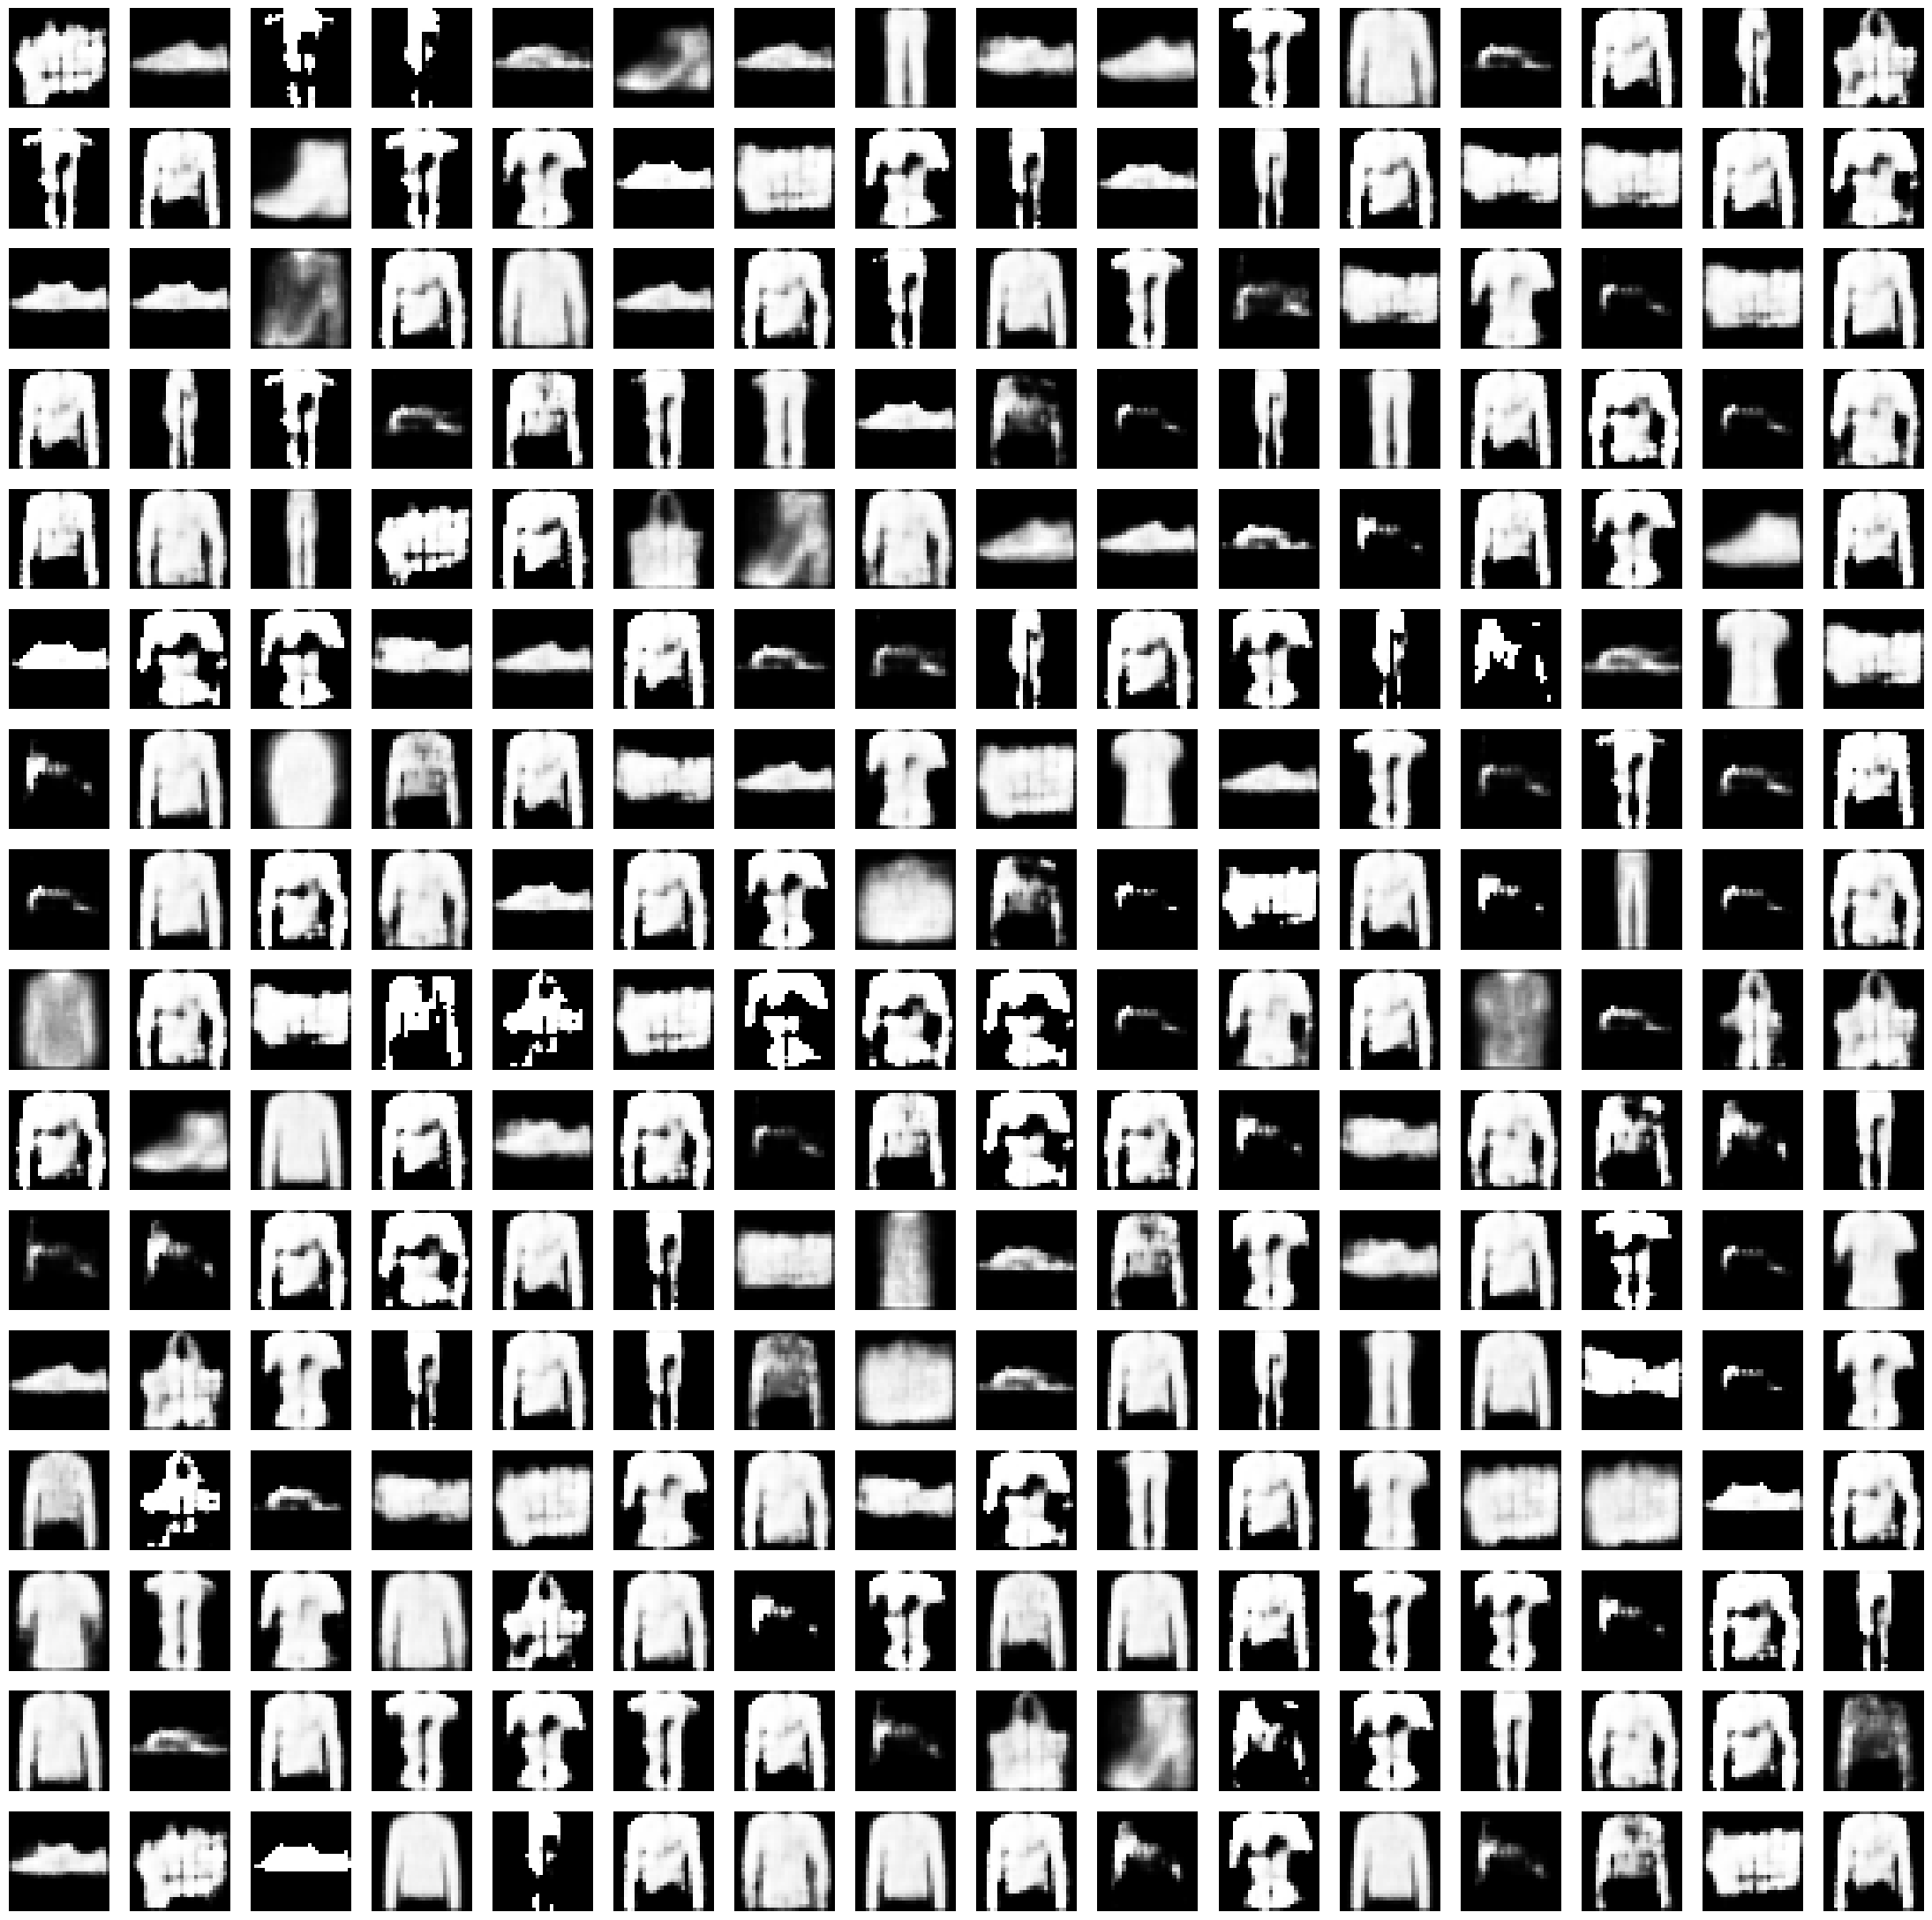

In [90]:
# generate 256 images taking z from normal distribution

z_mean = tf.random.normal(mean=0, stddev=4, shape=(256,2))
z_log_var = tf.random.normal(mean=0, stddev=4, shape=(256,1))

samples = vae.sampler(z_mean, z_log_var)
synths = vae.decoder(samples).numpy()

plt.figure(figsize=(28,28))

for i in range(256):
    plt.subplot(16,16,i+1)
    plt.imshow(synths[i].reshape((28, 28)), cmap="Greys_r")
    plt.axis('off')

plt.show()

tf.Tensor([[-2.8560364 -1.6878735]], shape=(1, 2), dtype=float32)


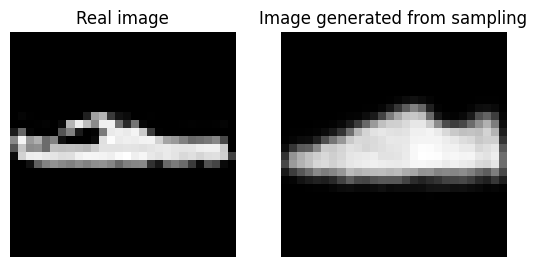

In [129]:
# find mean and log var for random sample
import random

idx = random.randint(0, len(X))
img = X[idx]
img = np.expand_dims(img, axis=0)

encoder_output = vae.encoder(img)
z = vae.sampler(encoder_output[0], encoder_output[1])

synth = vae.decoder(z).numpy()

plt.subplot(1, 2, 1)
plt.title("Real image")
plt.axis("off")
plt.imshow(img.reshape((28, 28)), cmap="Greys_r")
plt.subplot(1, 2, 2)
plt.title("Image generated from sampling")
plt.axis("off")
plt.imshow(synth.reshape((28, 28)), cmap="Greys_r")

print(z)

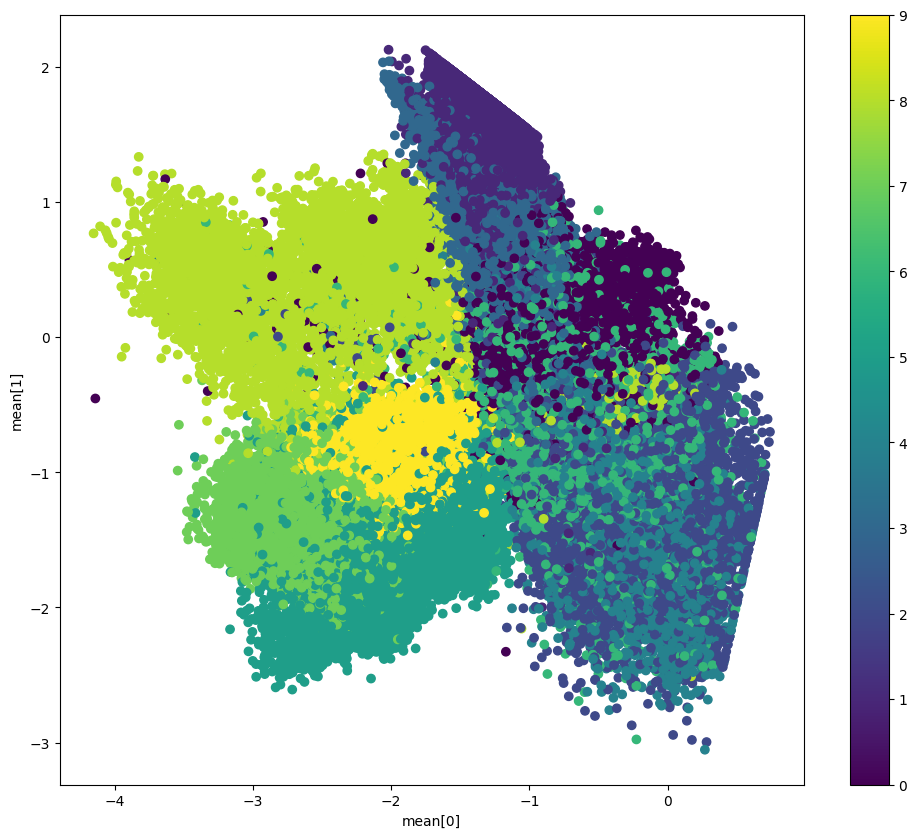

In [133]:
# visualize distribution

encoder_output = vae.encoder(X)
mean = encoder_output[0]

plt.figure(figsize=(12,10))
plt.scatter(mean[:, 0], mean[:, 1], c=Y)
plt.colorbar()
plt.xlabel("mean[0]")
plt.ylabel("mean[1]")
plt.show()